# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# <a class="anchor" id="Table of Contents">Table of Contents</a>

I. [Exploring Data](#Explory_tables)<br>
II. [Data Clean](#prep_tables)<br>
III.[Evaluating Model](#evalut_model)<br>
IV.[Conclusion](#conclusion)<br>


In [80]:
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pandas.plotting import table
import datetime
from time import time
import matplotlib.patches as mpatches
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, StandardScaler
from sklearn.metrics import fbeta_score, accuracy_score, f1_score

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# I. Exploring Data

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.info() # no NaN values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


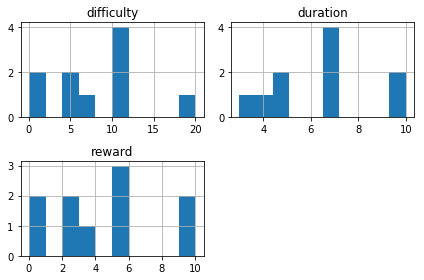

In [6]:
portfolio.hist()
plt.tight_layout();

plt.savefig('portfolio_hist_plot.png')

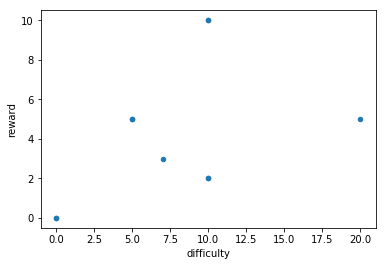

In [7]:
portfolio.plot.scatter('difficulty', 'reward');

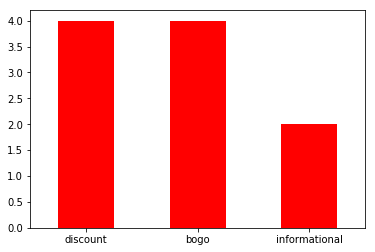

In [8]:
# Distribution of 'offer_type'
portfolio['offer_type'].value_counts().plot(kind='bar', color='r', rot=0);

plt.savefig('portfolio_offer_type.png')

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [9]:
profile.shape

(17000, 5)

In [10]:
profile.head() 

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.info() ## gender and income : missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [12]:
profile[['age', 'income']].describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


In [13]:
def table_to_img(df, filename):
    '''
    Saves Pandas dataframe to a .png file
    
    input: df - dataframe
    output: png file
    '''
    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111, frame_on=False)
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis

    the_table = table(ax, df, 
                      loc='center',
                      colWidths = [0.15, 0.15])
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(1.5, 1.5)
    
    fig.tight_layout()

    plt.savefig(filename + '.png')

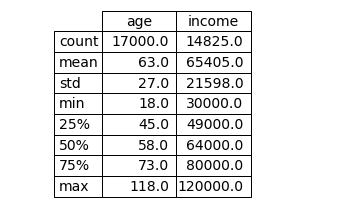

In [14]:
table_to_img(profile[['age', 'income']].describe().round(), 'profile_desc')

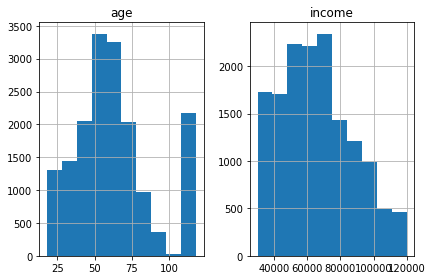

In [15]:
profile[['age', 'income']].hist()
plt.tight_layout();

plt.savefig('profile_hist.png')

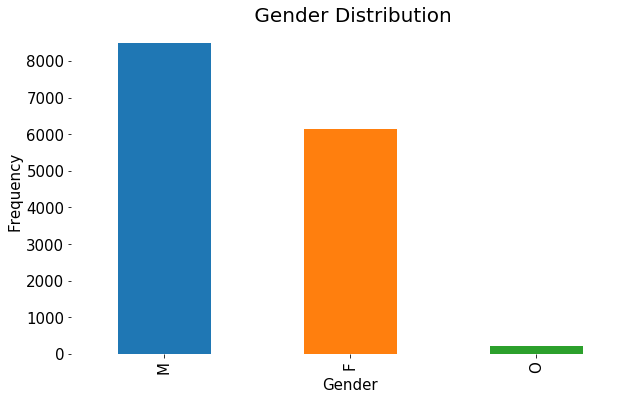

In [16]:
ax = profile["gender"].value_counts().plot.bar(
    figsize=(10,6),
    fontsize=15,
)

ax.set_title(" Gender Distribution", fontsize=20)
ax.set_xlabel("Gender", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [17]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [19]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [20]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


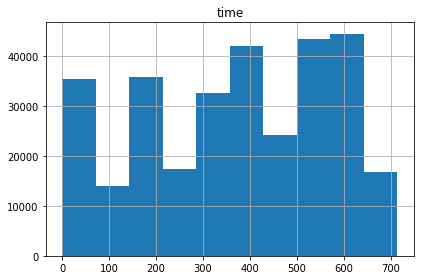

In [21]:
transcript.hist()
plt.tight_layout();

plt.savefig('transcript_hist.png')

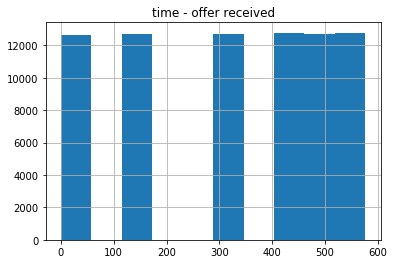

In [22]:
transcript[transcript['event'] == 'offer received'].hist()
plt.title('time - offer received');

plt.savefig('transcript_offer received.png')

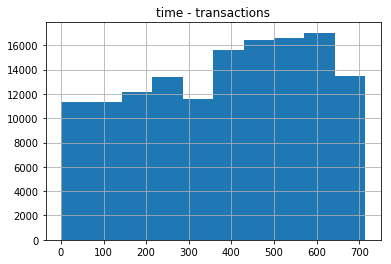

In [23]:
transcript[transcript['event'] == 'transaction'].hist()
plt.title('time - transactions');

plt.savefig('transcript_transactions.png')

# Check data

In [24]:
print("\nCheck for missing values:\n")

for file in [portfolio, profile, transcript]:

    print(file.shape)
    print(file.isnull().sum())
    print("\n")


Check for missing values:

(10, 6)
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


(17000, 5)
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


(306534, 4)
event     0
person    0
time      0
value     0
dtype: int64




In [25]:
print("\nCheck for duplicate ids:\n")

for file in [portfolio, profile]:

    print(file.shape)
    print(len(file[file.id.duplicated()]))
    print("\n")


Check for duplicate ids:

(10, 6)
0


(17000, 5)
0




# II. Data clean

**Dataset reviews**

* Some demographic groups make purchases regardless of whether they receive an offer. Ideally we would like to group them separately.
* The "transaction" event does not have any "offer_id" associated to it, so we have to figure out which transactions are connected to particular offer and which ones are not (customer bought something casually).

**Data clean strategies**

* colums of portfolio.channels can be seperated to better understanding and classification
* 'Age'>118 seems not reasonable and the related information are missing
* Incompatible units: ofer duration days versus event time in hours
* There are NaN values in 'gender' and 'income'


In [26]:
def cleaning_portfolio(df=portfolio):
    """
    INPUT:
        portfolio dataframe
        
    OUTPUT:
        A new datafrem with:
        - One-hot encode channels column
        - One-hot encode offer_type column   
        
    """
        
    # One-hot encode channels column
    # https://stackoverflow.com/questions/18889588/create-dummies-from-column-with-multiple-values-in-pandas
    channels = portfolio["channels"].str.join(sep="*").str.get_dummies(sep="*")
    
    # One-hot encode offer_type column
    offer_type = pd.get_dummies(portfolio['offer_type'])
    
    # Concat one-hot and df
    new_df = pd.concat([df, channels, offer_type], axis=1, sort=False)
    
    # Remove channels and offer_type
    new_df = new_df.drop(['channels', 'offer_type'], axis=1)
    
    # Organize columns
    columns = ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    new_df = new_df[columns]
    
    return new_df

In [27]:
clean_portfolio = cleaning_portfolio(portfolio)
clean_portfolio = clean_portfolio.rename(columns={"id": "offer_id" })
clean_portfolio

,offer_id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7,3,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,10,2,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,3,0,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,0,1,0,1,0


In [28]:
clean_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
offer_id         10 non-null object
difficulty       10 non-null int64
duration         10 non-null int64
reward           10 non-null int64
email            10 non-null int64
mobile           10 non-null int64
social           10 non-null int64
web              10 non-null int64
bogo             10 non-null uint8
discount         10 non-null uint8
informational    10 non-null uint8
dtypes: int64(7), object(1), uint8(3)
memory usage: 750.0+ bytes


In [29]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [30]:
def cleaning_profile(profile = profile):
    """
    INPUT:
        Profile datafram
        
    OUTPUT:
        A new dataframe whithout income values equal to null and age equal to 118
    """
    # drop lines with income = NaN and age == 118
    new_df = profile.drop(profile[(profile["income"].isnull()) & (profile["age"] == 118)].index)
    
    # Age for range and One-hot 
    # https://dfrieds.com/data-analysis/bin-values-python-pandas
    range_ages = pd.cut(x=new_df["age"], bins=[18, 20, 29, 39, 49, 59, 69, 79, 89, 99, 102])
    
    # One-hot encode ages column
    ages_dummies = pd.get_dummies(range_ages)
    
    # Income for range and One-hot
    # One-hot encode income column
    range_income = pd.cut(x=new_df["income"], bins=[30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000,  120000])
    income_dummies = pd.get_dummies(range_income)
    
    # One-hot encode Gender column
    gender_dummies = pd.get_dummies(new_df["gender"])
    
    # Concat
    new_df = pd.concat([new_df, ages_dummies, income_dummies, gender_dummies ], axis=1, sort=False)
    
    # Drop
    new_df = new_df.drop(["age", "gender", "income"], axis=1)
    
    new_df['became_member_on'] = new_df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    
    return new_df

In [31]:
clean_profile = cleaning_profile()
clean_profile.rename(columns={'id': 'customer_id'}, inplace=True)
clean_profile.head()

,became_member_on,customer_id,"(18, 20]","(20, 29]","(29, 39]","(39, 49]","(49, 59]","(59, 69]","(69, 79]","(79, 89]",...,"(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]",F,M,O
1,2017-07-15,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
5,2018-04-26,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8,2018-02-09,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
12,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [32]:
clean_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 24 columns):
became_member_on    14825 non-null datetime64[ns]
customer_id         14825 non-null object
(18, 20]            14825 non-null uint8
(20, 29]            14825 non-null uint8
(29, 39]            14825 non-null uint8
(39, 49]            14825 non-null uint8
(49, 59]            14825 non-null uint8
(59, 69]            14825 non-null uint8
(69, 79]            14825 non-null uint8
(79, 89]            14825 non-null uint8
(89, 99]            14825 non-null uint8
(99, 102]           14825 non-null uint8
(30000, 40000]      14825 non-null uint8
(40000, 50000]      14825 non-null uint8
(50000, 60000]      14825 non-null uint8
(60000, 70000]      14825 non-null uint8
(70000, 80000]      14825 non-null uint8
(80000, 90000]      14825 non-null uint8
(90000, 100000]     14825 non-null uint8
(100000, 110000]    14825 non-null uint8
(110000, 120000]    14825 non-null uint8
F                   

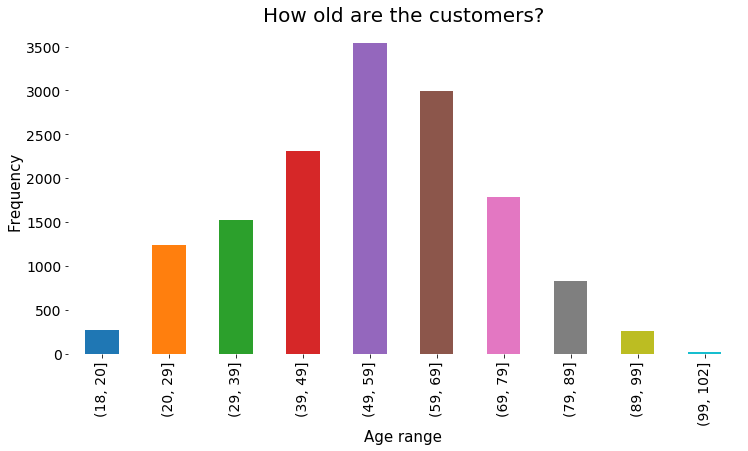

In [33]:
ax = clean_profile[clean_profile.columns[2:12]].sum().plot.bar(
    figsize=(12,6),
    fontsize=14,

)

ax.set_title("How old are the customers?", fontsize=20)
ax.set_xlabel("Age range", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

plt.savefig('How_old_are_the _customers.png')

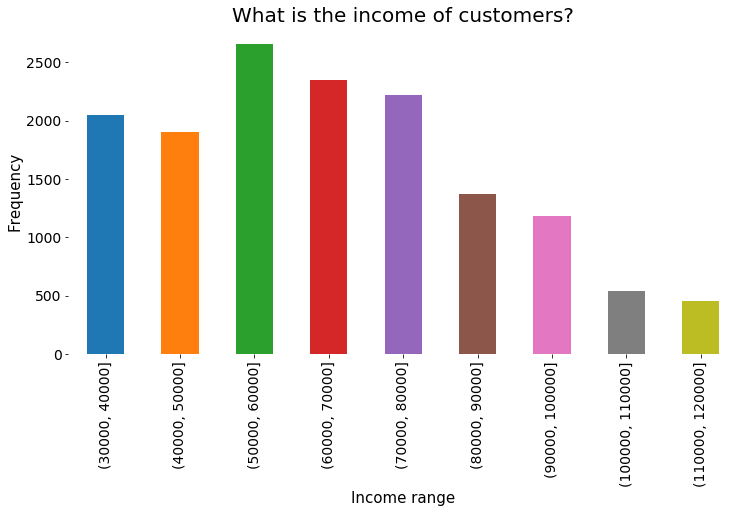

In [34]:
ax = clean_profile[clean_profile.columns[12:21]].sum().plot.bar(
    figsize=(12,6),
    fontsize=14,

)

ax.set_title("What is the income of customers?", fontsize=20)
ax.set_xlabel("Income range", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

plt.savefig('What_is_the_income_distribution.png')

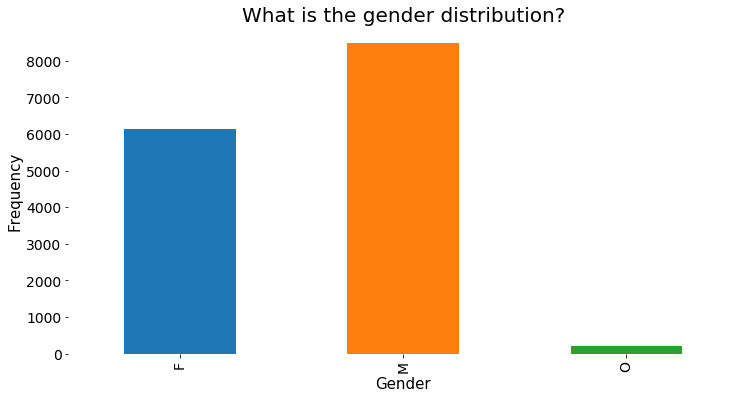

In [35]:
ax = clean_profile[clean_profile.columns[21:]].sum().plot.bar(
    figsize=(12,6),
    fontsize=14,

)

ax.set_title("What is the gender distribution?", fontsize=20)
ax.set_xlabel("Gender", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

In [36]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [37]:
def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ["amount"]:
        return list(val.values())[0]
    
def create_reward_col(val):
    if list(val.keys())[0] in ["reward"]:
        return list(val.values())[0]

In [38]:
def cleaning_transcript(transcript = transcript):
    """
    INPUT:
        transcript dataframe
    
    OUTPUT:
        
    
    """
    #
    transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
    transcript["amount"] = transcript.value.apply(create_amount_col)
    #transcript["reward"] = transcript.value.apply(create_reward_col)
    
    #  One-hot encode event column
    event = pd.get_dummies(transcript['event'])
    
    # Concat one-hot and df
    new_df = pd.concat([transcript, event], axis=1, sort=False)
    
    # Drop Trna
    transaction = new_df[new_df["transaction"]==1]
    new_df = new_df.drop(transaction.index)
    
    # Drop
    new_df = new_df.drop(columns = ["event","value", "amount", "transaction"])
    
    return new_df

In [39]:
clean_transcript = cleaning_transcript(transcript)

clean_transcript.head()

,person,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


In [96]:
clean_transcript.time.value_counts()

408    15635
576    15607
504    15471
336    15242
168    15156
0      14928
414     2185
510     2145
582     2127
342     1917
174     1859
588     1819
420     1769
516     1756
6       1709
348     1527
180     1526
594     1450
426     1444
522     1375
12      1365
186     1286
600     1274
354     1226
432     1221
528     1164
18      1136
606     1126
438     1063
192     1052
       ...  
684      245
270      233
264      231
102      223
696      222
96       222
690      217
108      212
282      212
276      200
288      198
120      196
114      180
702      160
708      156
714      153
300      150
312      144
294      143
132      138
138      134
150      127
144      122
306      122
126      119
156      114
324      103
318      102
330       95
162       75
Name: time, Length: 120, dtype: int64

In [40]:
clean_transcript.rename(columns={'person':'customer_id'}, inplace=True)

In [41]:
clean_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 6 columns):
customer_id        167581 non-null object
time               167581 non-null int64
offer_id           167581 non-null object
offer completed    167581 non-null uint8
offer received     167581 non-null uint8
offer viewed       167581 non-null uint8
dtypes: int64(1), object(2), uint8(3)
memory usage: 5.6+ MB


In [42]:
clean_transcript[clean_transcript["offer completed"]==1].shape

(33579, 6)

In [43]:
clean_transcript.head()

,customer_id,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


In [230]:
clean_profile.head()

,became_member_on,customer_id,"(18, 20]","(20, 29]","(29, 39]","(39, 49]","(49, 59]","(59, 69]","(69, 79]","(79, 89]",...,"(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]",F,M,O
1,2017-07-15,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
5,2018-04-26,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8,2018-02-09,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
12,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [44]:
clean_portfolio.head()

,offer_id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0


# Prepare data

In [64]:
def concat_tables():
   
    # TODO: Merge de transcript com portfolio tendo como referencia offer_id
    final_transcript = clean_transcript.merge(clean_portfolio[clean_portfolio.columns])
    
    # TODO: Merge profile
    # Para persons que não estão nos dois dataframes serão descartados.
    final_transcript = final_transcript.merge(clean_profile[clean_profile.columns])
    
    columns_names = ['customer_id', 'time', 'offer_id', 
                'offer completed', 'offer received',' offer viewed', 
                'difficulty', 'duration', 'reward', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational','became_member_on',
                "18-20", "20-29", "29-39", "39-49", "49-59", "59-69", "69-79", "79-89", "89-99", "99-102", 
                "30-40K", "40-50K", "50-60K", "60-70K", "70-80K", "80-90K", "90-100K", "100-110K", "110-120K", 
                'F', 'M', 'O']
    final_transcript.columns = columns_names
    
    # TODO: Reorganize colunas
    arrume = ['customer_id', 'offer_id', 'time', 
          'difficulty', 'duration', 'reward', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational','became_member_on',
          "18-20", "20-29", "29-39", "39-49", "49-59", "59-69", "69-79", "79-89", "89-99", "99-102", 'F', 'M', 'O',
          "30-40K", "40-50K", "50-60K", "60-70K", "70-80K", "80-90K", "90-100K", "100-110K", "110-120K", 
          'offer received',' offer viewed', 'offer completed'     
         ]     
    return final_transcript[arrume]

In [65]:
final_transcript = concat_tables()
final_transcript.head()

,customer_id,offer_id,time,difficulty,duration,reward,email,mobile,social,web,...,50-60K,60-70K,70-80K,80-90K,90-100K,100-110K,110-120K,offer received,offer viewed,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,7,5,1,1,0,1,...,0,0,0,0,1,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,5,7,5,1,1,0,1,...,0,0,0,0,1,0,0,0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,132,5,7,5,1,1,0,1,...,0,0,0,0,1,0,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,5,5,5,1,1,1,1,...,0,0,0,0,1,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,510,5,5,5,1,1,1,1,...,0,0,0,0,1,0,0,0,0,1


In [63]:
final_transcript.shape

(148805, 39)

In [48]:
final_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 39 columns):
customer_id         148805 non-null object
offer_id            148805 non-null object
time                148805 non-null int64
difficulty          148805 non-null int64
duration            148805 non-null int64
reward              148805 non-null int64
email               148805 non-null int64
mobile              148805 non-null int64
social              148805 non-null int64
web                 148805 non-null int64
bogo                148805 non-null uint8
discount            148805 non-null uint8
informational       148805 non-null uint8
became_member_on    148805 non-null datetime64[ns]
18-20               148805 non-null uint8
20-29               148805 non-null uint8
29-39               148805 non-null uint8
39-49               148805 non-null uint8
49-59               148805 non-null uint8
59-69               148805 non-null uint8
69-79               148805 non-null ui

In [50]:
# TODO: Total number of records
n_records = len(final_transcript.index)

# TODO: Number of records where offer completed is == 1
completed_1 = final_transcript[final_transcript["offer completed"] == 1].shape[0]

# TODO: Number of records where offer completed is == 0
completed_0 = final_transcript[final_transcript["offer completed"] == 0].shape[0]

# TODO: Percentage of offer completed
perc_completed = (completed_1 / completed_0) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals that completed: {}".format(completed_1))
print("Individuals that NOT completed: {}".format(completed_0))
print("Percentage of individuals that completed: {0:.2f}%".format(perc_completed))

Total number of records: 148805
Individuals that completed: 32444
Individuals that NOT completed: 116361
Percentage of individuals that completed: 27.88%


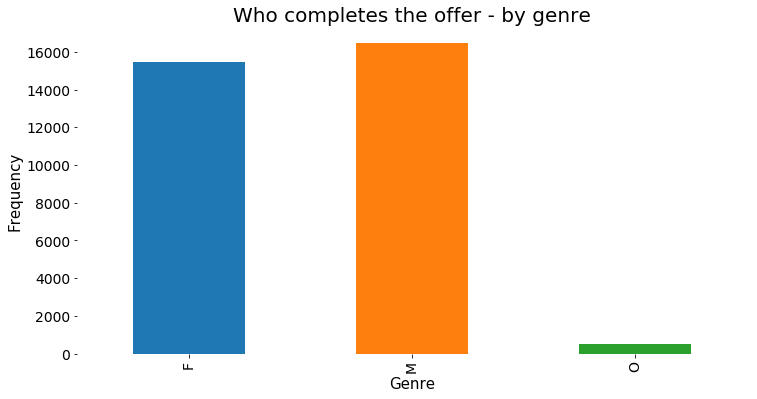

In [51]:
ax = final_transcript[final_transcript["offer completed"] == 1][["F","M", "O"]].sum().plot.bar(
    figsize=(12,6),
    fontsize=14,

)

ax.set_title("Who completes the offer - by genre", fontsize=20)
ax.set_xlabel("Genre", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

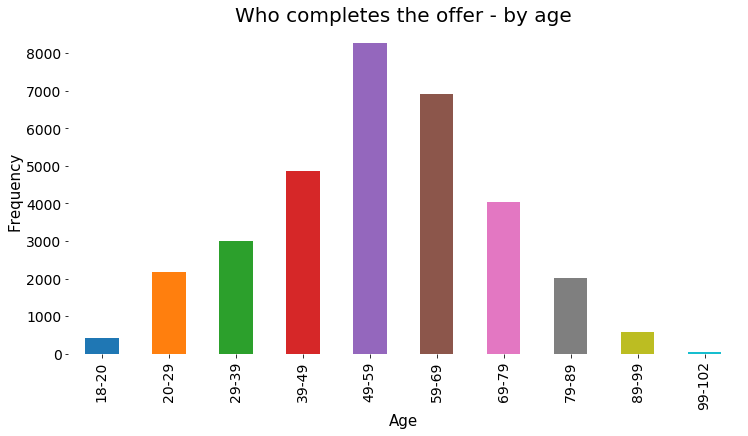

In [52]:
ax = final_transcript[final_transcript["offer completed"] == 1][['18-20',
       '20-29', '29-39', '39-49', '49-59', '59-69', '69-79', '79-89', '89-99',
       '99-102']].sum().plot.bar(
    figsize=(12,6),
    fontsize=14,
)
ax.set_title("Who completes the offer - by age", fontsize=20)
ax.set_xlabel("Age", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)



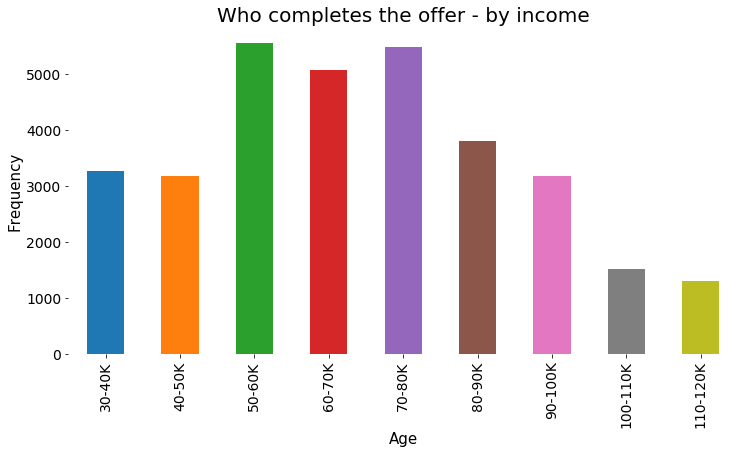

In [53]:
ax = final_transcript[final_transcript["offer completed"] == 1][['30-40K', '40-50K', '50-60K', '60-70K',
       '70-80K', '80-90K', '90-100K', '100-110K', '110-120K']].sum().plot.bar(
    figsize=(12,6),
    fontsize=14,

)

ax.set_title("Who completes the offer - by income", fontsize=20)
ax.set_xlabel("Age", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

# Map of custome profile

In [54]:
prof_1 = profile[(profile["gender"]=="M") & (profile["age"] > 29) & (profile["age"] < 69) & (profile["income"] > 30000) & (profile["income"] < 100000)]

In [55]:
prof_2 = profile[(profile["gender"]=="F") & (profile["age"] > 29) & (profile["age"] < 69) & (profile["income"] > 30000) & (profile["income"] < 100000)]

In [56]:
prof_1.shape, prof_2.shape

((5565, 5), (3632, 5))

In [57]:
custom_profile =  prof_1.append(prof_2)

In [58]:
idx = []
for person in custom_profile["id"]:
    list = final_transcript[final_transcript["customer_id"] == person].index.tolist()
    idx.extend(list)

In [59]:
percent = len(idx) * 100 / final_transcript.shape[0]
print("The proportion of clients who have completed offers are men or women between 39 and 69 years old and with income between 30 and 100 thousand is {0:.2f}%.".format(percent))

The proportion of clients who have completed offers are men or women between 39 and 69 years old and with income between 30 and 100 thousand is 62.35%.


In [66]:
final_transcript[final_transcript["offer completed"] == 1][["offer received", ' offer viewed']].sum()

offer received    0
 offer viewed     0
dtype: int64

In [67]:
final_transcript = final_transcript.drop(["offer received", ' offer viewed', 'informational', "became_member_on"], axis=1)

In [68]:
# Drop feautures
final_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 35 columns):
customer_id        148805 non-null object
offer_id           148805 non-null object
time               148805 non-null int64
difficulty         148805 non-null int64
duration           148805 non-null int64
reward             148805 non-null int64
email              148805 non-null int64
mobile             148805 non-null int64
social             148805 non-null int64
web                148805 non-null int64
bogo               148805 non-null uint8
discount           148805 non-null uint8
18-20              148805 non-null uint8
20-29              148805 non-null uint8
29-39              148805 non-null uint8
39-49              148805 non-null uint8
49-59              148805 non-null uint8
59-69              148805 non-null uint8
69-79              148805 non-null uint8
79-89              148805 non-null uint8
89-99              148805 non-null uint8
99-102             148805 

In [69]:
# Split the data into features and target label
target = final_transcript['offer completed']
features = final_transcript.drop('offer completed', axis = 1)

In [70]:
print("{} total features.".format(len(features.columns)))

34 total features.


In [213]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 42 columns):
customer_id            148805 non-null object
time                   148805 non-null int64
offer_id               148805 non-null object
duration               148805 non-null int64
email                  148805 non-null int64
mobile                 148805 non-null int64
social                 148805 non-null int64
web                    148805 non-null int64
difficulty_0           148805 non-null uint8
difficulty_5           148805 non-null uint8
difficulty_7           148805 non-null uint8
difficulty_10          148805 non-null uint8
difficulty_20          148805 non-null uint8
reward_0               148805 non-null uint8
reward_2               148805 non-null uint8
reward_3               148805 non-null uint8
reward_5               148805 non-null uint8
reward_10              148805 non-null uint8
offer_type_bogo        148805 non-null uint8
offer_type_discount    148805 no

# Normalize features

In [71]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

numerical = features.columns[2:6]

features_log_minmax_transform = pd.DataFrame(data = features)
features_log_minmax_transform[numerical] = scaler.fit_transform(features[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,customer_id,offer_id,time,difficulty,duration,reward,email,mobile,social,web,...,O,30-40K,40-50K,50-60K,60-70K,70-80K,80-90K,90-100K,100-110K,110-120K
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.000000,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.008403,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.184874,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0.705882,0.25,0.285714,0.5,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0.714286,0.25,0.285714,0.5,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0


In [72]:
features_final = features_log_minmax_transform[features_log_minmax_transform.columns[2:]]

# Split data

In [73]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    target, 
                                                    test_size = 0.20, 
                                                    random_state = 42,
                                                   stratify=target)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 119044 samples.
Testing set has 29761 samples.


# III. Evaluating model

In [81]:
accuracy = accuracy_score(y_train,np.ones(len(y_train)))
fscore = fbeta_score(y_train,np.ones(len(y_train)), beta=0.5)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, fscore: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2180, fscore: 0.2584]


In [82]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    #  Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    #  Calculate the training time
    results['train_time'] = end - start
        
    #  Get the predictions on the test set(X_test),
    #   then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
    
    #  Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    #  Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #  Compute F-score on the the first 300 training samples using fbeta_score()
    #results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    results['f_train'] = f1_score(y_train[:300], predictions_train)
        
    # Compute F-score on the test set which is y_test
    #results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    results['f_test'] = f1_score(y_train[:300], predictions_train)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [83]:
def evaluate(results, accuracy, f1):    
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

DecisionTreeClassifier trained on 1190 samples.
DecisionTreeClassifier trained on 11904 samples.
DecisionTreeClassifier trained on 119044 samples.
GaussianNB trained on 1190 samples.
GaussianNB trained on 11904 samples.
GaussianNB trained on 119044 samples.
RandomForestClassifier trained on 1190 samples.
RandomForestClassifier trained on 11904 samples.
RandomForestClassifier trained on 119044 samples.


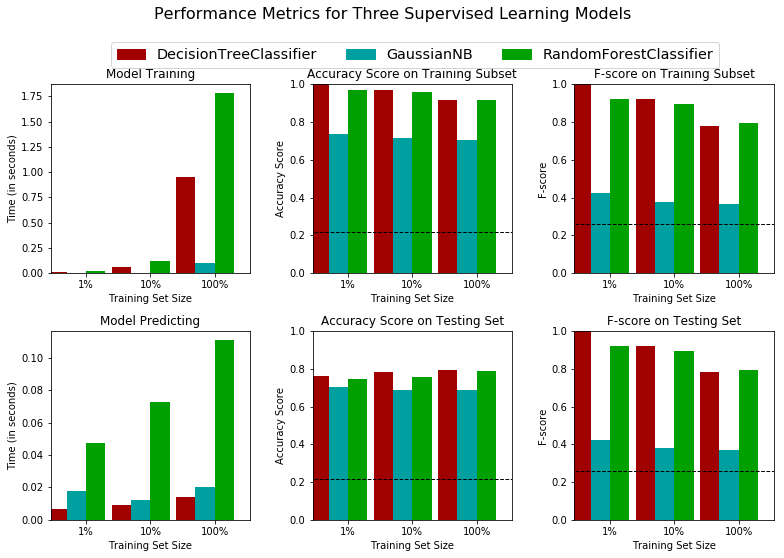

In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


#Initialize the three models
clf_A = DecisionTreeClassifier(random_state =42) #DecisionTree
clf_B = GaussianNB() #NainveBayes
# n_estimators=10 is a default parameter. Necess for not error message. 
clf_C = RandomForestClassifier(random_state =42, n_estimators=10) #EnsembleMethods 

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)

samples_100 =  int(len(y_train))
samples_10 =  int((samples_100 * 10/100))
samples_1 =   int((samples_100 * 1)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

# Model Tuning

In [87]:
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Initialize the classifier
clf = RandomForestClassifier(random_state =42, n_estimators=20)

# Create the parameters list you wish to tune, using a dictionary if needed.

parameters = {'max_features':['auto', 'sqrt'], 'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]} 

#  Make an fbeta_score scoring object using make_scorer()
beta= 0.01
#scorer = make_scorer(fbeta_score, beta=beta)
scorer = make_scorer(precision_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, cv=3, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = beta)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = beta)))

Unoptimized model
------
Accuracy score on testing data: 0.7881
F-score on testing data: 0.5180

Optimized Model
------
Final accuracy score on the testing data: 0.7947
Final F-score on the testing data: 0.6121


In [88]:
# Print a Confusion Matrix
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = conf_mtx = confusion_matrix(y_test, best_predictions).ravel()
conf_mtx = np.array([[tp, fn],[fp, tn]])
conf_mtx

array([[ 1031,  5458],
       [  653, 22619]])

In [89]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, support, nada = precision_recall_fscore_support(y_test, best_predictions, average='binary', pos_label=1)
print(f"The precision of model is {precision:0.4f}.")
print(f"The recall of model is {recall:0.4f}.")

The precision of model is 0.6122.
The recall of model is 0.1589.


In [90]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

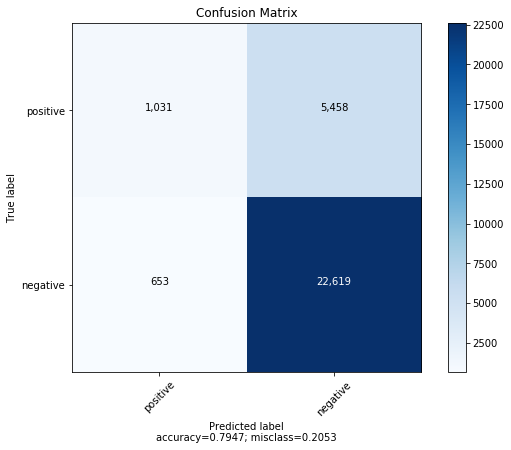

In [91]:
plot_confusion_matrix(cm           = conf_mtx, 
                      normalize    = False,
                      target_names = ['positive', 'negative'],
                      title        = "Confusion Matrix")

A confusion matrix shows that we have a low false positive number. which indicates a low number of promotion submissions to customers who will not complete the offer. False negative is high, So I stop sending promotions to anyone who would complete the offer without even receiving the offer.

In [92]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

# Feature importance

In [95]:
def feature_plot(importances, X_train, y_train, n=5):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:n]]
    values = importances[indices][:n]

    # Creat the plot
    fig = plt.figure(figsize = (12,6))
    plt.title(f"Normalized Weights for First {n} Predictive Features", fontsize = 16)
    plt.bar(np.arange(n), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(n) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(n), columns)
    #pl.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper left')
    plt.tight_layout()
    sns.despine(bottom=True, left=True)
    plt.show()

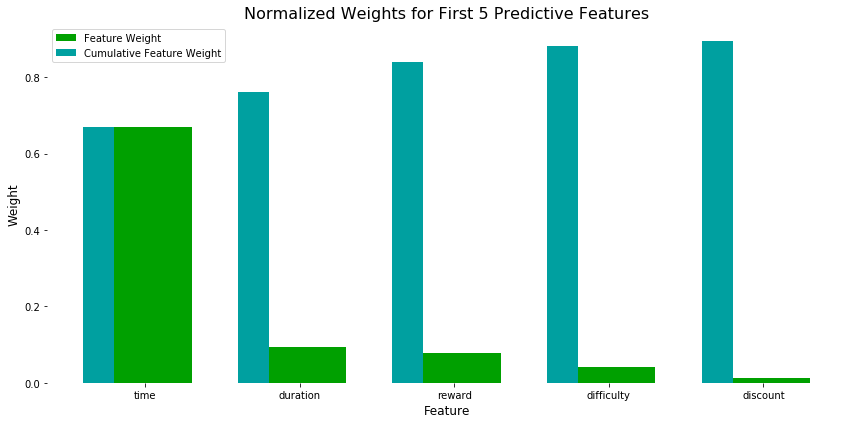

In [96]:
model = best_clf.fit(X_train, y_train)
#Extract the feature importances 
importances = model.feature_importances_
# Plot
feature_plot(importances, X_train, y_train, 5)

# IV. Conclusion

After the data wrangling, We can see the proportion of clients who have completed offers are men or women between 39 and 69 years old and with income between 30 and 100 thousand is 62.35%.

After mapping the customer profile that has completed an offer, we continue to analyze to determine how important features are.

The important features are:

* Time: time in hours since start of test
* duration - time for offer to be open, in days
* Reward: reward given for completing an offer
* difficulty: minimum required spend to complete an offer
* Discount: types of offer. receive discount when completing offer

Three models have been performed: DecisionTreeClassifier, GaussianNB and RandomForestClassidier. The results show the most promising results are from RandomForestClassifier.

**Prediction accuracy**

Original accuracy

* Accuracy score: 0.218 
* fscore: 0.2584 


Model Evaluation:

* Accuracy score: 0.7881
* fscore: 0.518

Optimized model:

* Accuracy score: 0.7947
* fscore: 0.6124

With better precision, we have better optimization in sending promotions.

* The precision of model is 0.6122.
* The recall of model is 0.1589.


A confusion matrix shows that we have a low false positive number. which indicates a low number of promotion submissions were sent to customers who will not complete the offer. False negative is high, so stoping sending promotions to anyone who would complete the offer without even receiving the offer seems to be reasonable.